In [415]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

In [416]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [417]:
def test_normality(data):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    sb.distplot(data)
    plt.show()
    ks_stat, ks_p = kstest(data, "norm")
    print("Kolmogorov-Smirnov Test Results: ")
    print("Test Statistics = ", ks_stat)
    print("P-value = ", ks_p)
    if ks_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")
    print("------------------------------------------------")
    sh_stat, sh_p = shapiro(data)
    print("Shapiro-Wilk Test Results: ")
    print("Test Statistics = ", sh_stat)
    print("P-value = ", sh_p)
    if sh_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")    

In [418]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [419]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [420]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")

In [421]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data.interpolate(inplace=True)
dates = list(ether_data.index)

In [422]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2252 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [423]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.252000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.323084e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.037117e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.480000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.942500e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


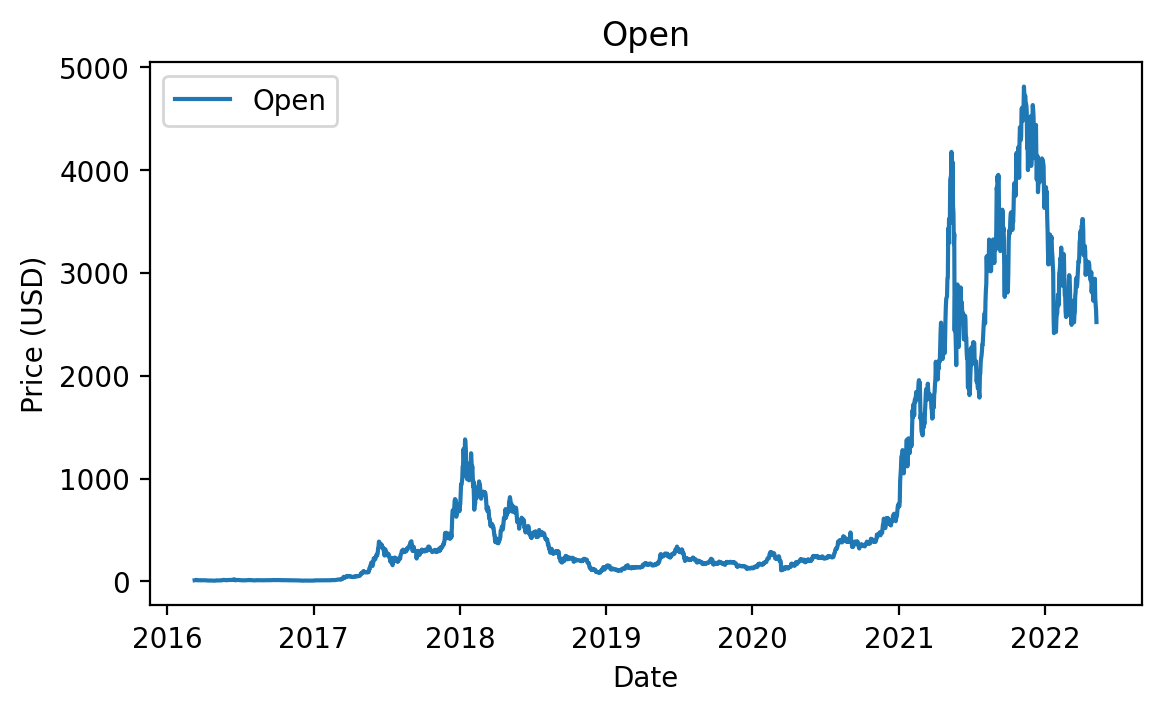

In [424]:
plot(data_label_pairs=[(ether_data["Open"], "Open")], x_label="Date", y_label="Price (USD)", title="Open")

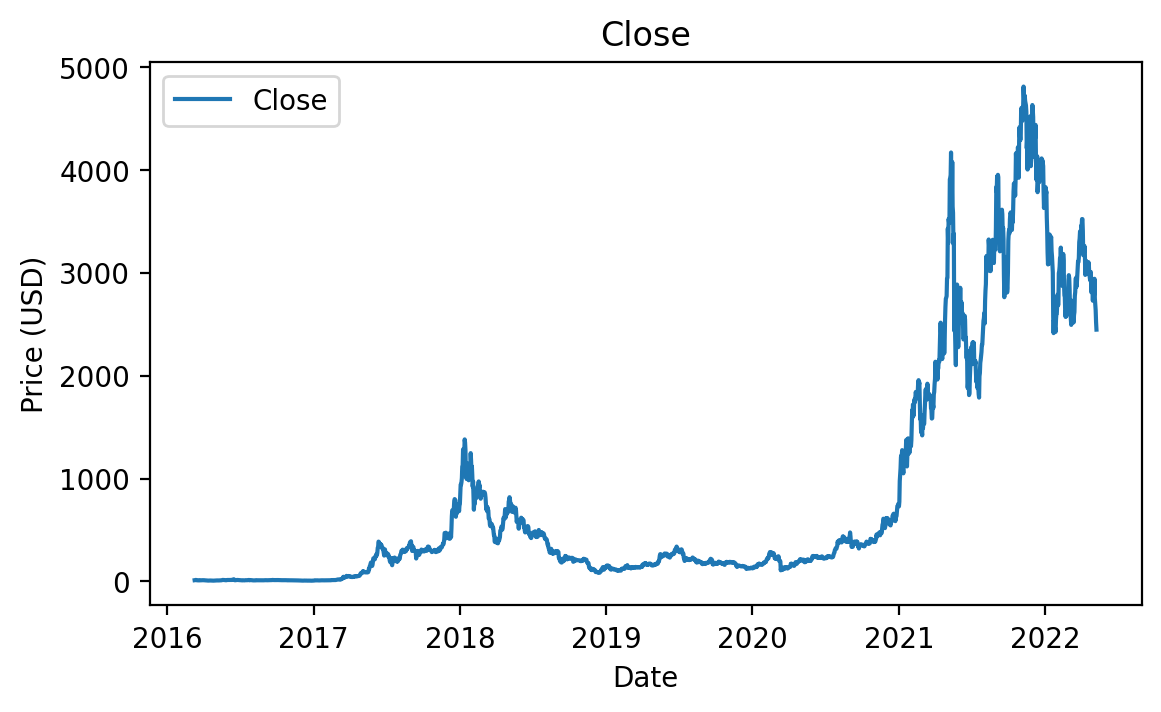

In [425]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Close")

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


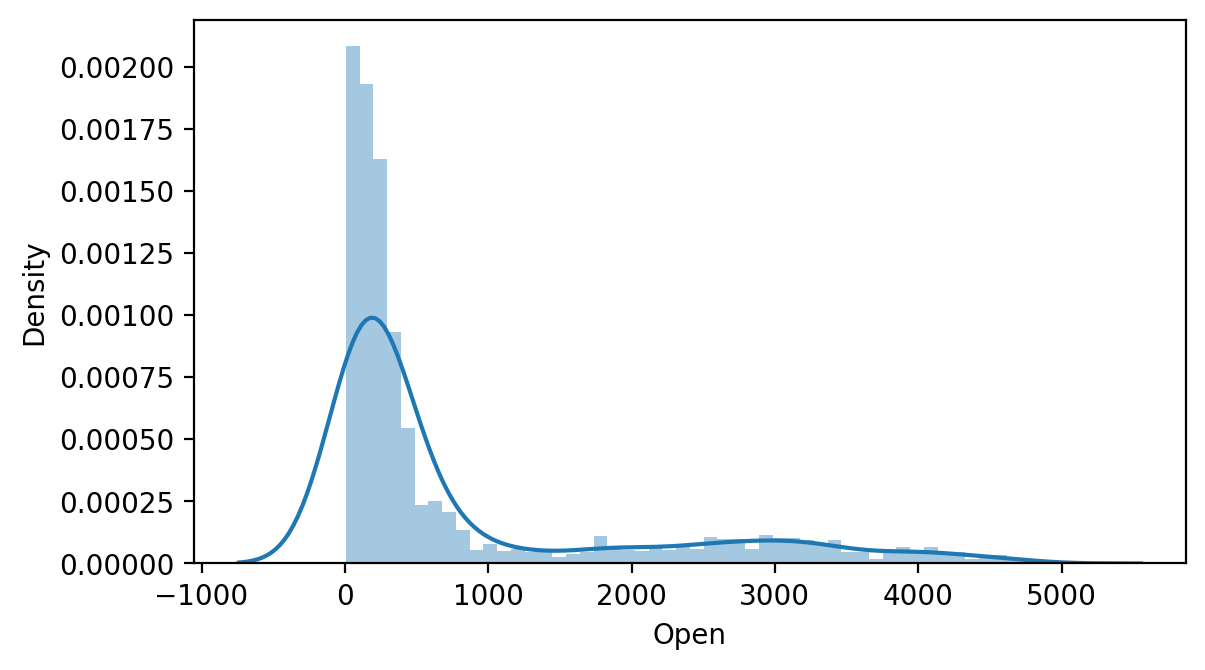

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999999880529
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6839131116867065
P-value =  0.0
Not Gausssian.


In [426]:
test_normality(ether_data["Open"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


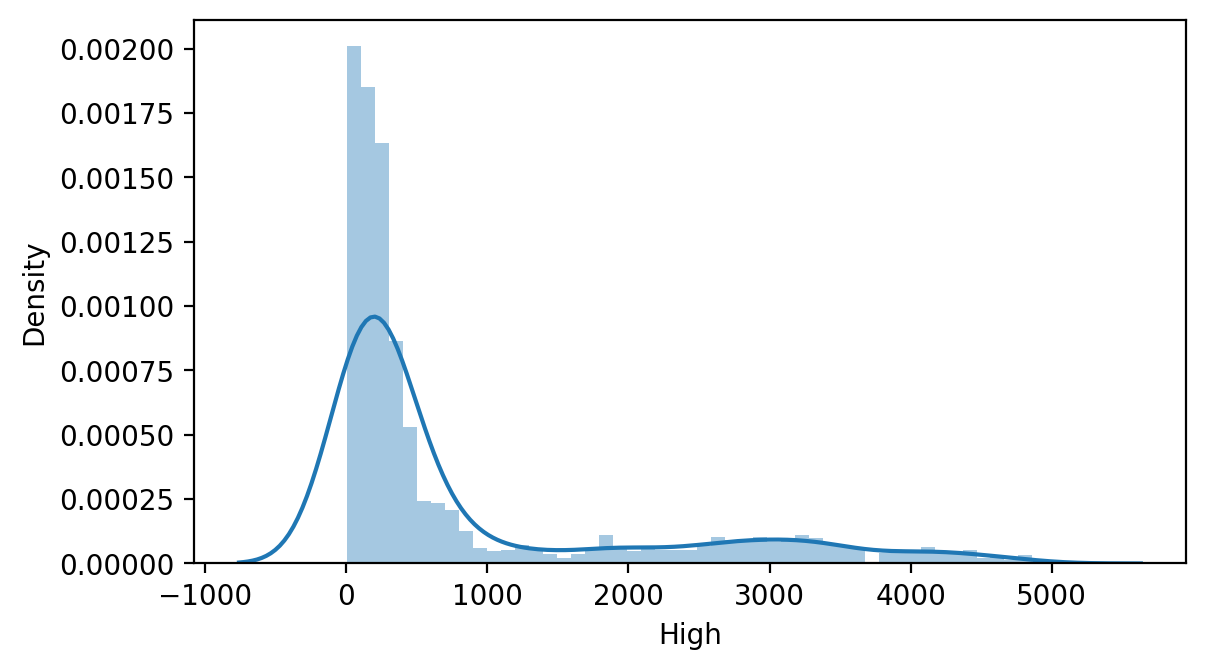

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999999876
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.685326099395752
P-value =  0.0
Not Gausssian.


In [427]:
test_normality(ether_data["High"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


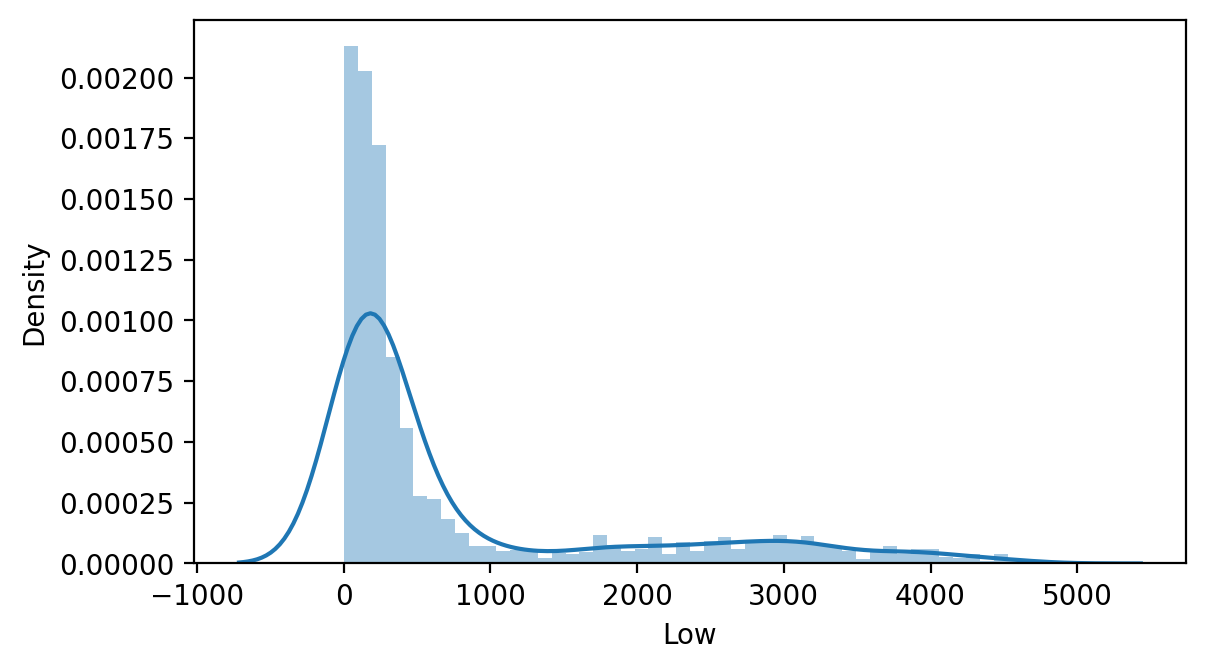

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999976856642
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6821624040603638
P-value =  0.0
Not Gausssian.


In [428]:
test_normality(ether_data["Low"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


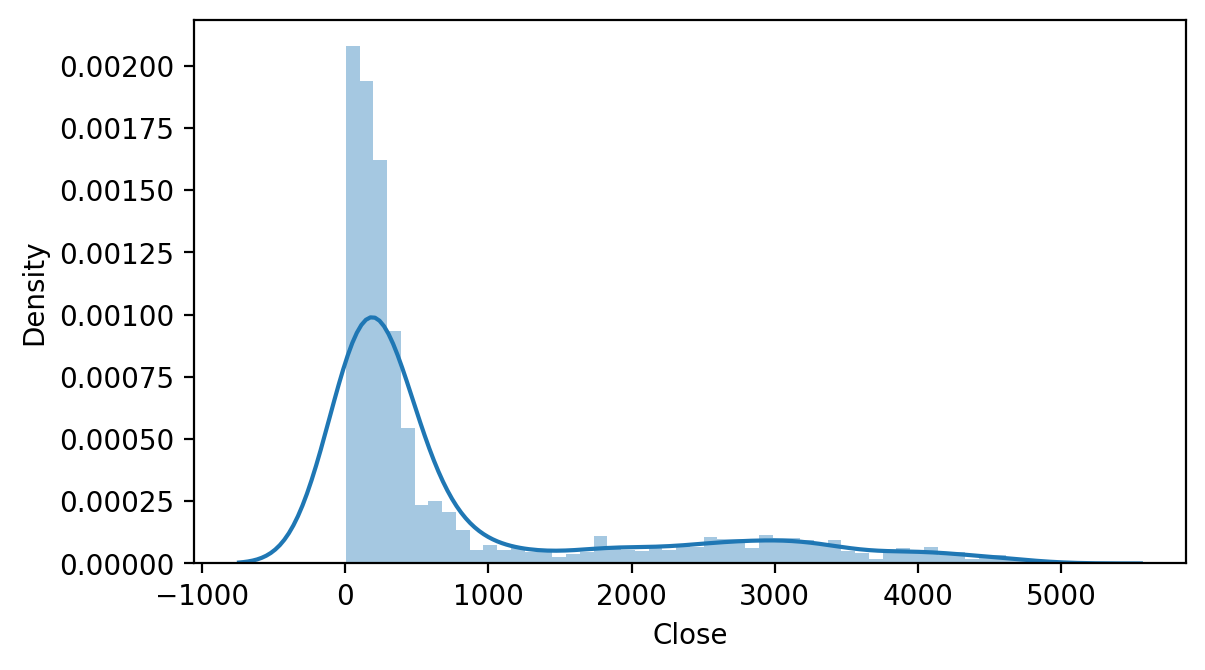

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999989579
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6844182014465332
P-value =  0.0
Not Gausssian.


In [429]:
test_normality(ether_data['Close'])

In [430]:
ether_data_uni = pd.DataFrame(ether_data, columns=["Close"])

In [431]:
ether_data_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [432]:
ether_data_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


In [433]:
ether_data_uni.describe()

,Close
count,2252.000000
mean,813.961607
std,1163.604697
min,6.700000
25%,135.460000
50%,258.900000
75%,759.147500
max,4808.380000


In [434]:
uni_training_size = int(len(ether_data_uni) * 0.80)
uni_test_size = len(ether_data_uni) - uni_training_size
train_ether_uni = ether_data_uni[:uni_training_size]
test_ether_uni = ether_data_uni[uni_training_size:]

In [435]:
train_ether_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2021-02-08,1750.18
2021-02-09,1770.63
2021-02-10,1742.09


In [436]:
test_ether_uni

,Close
Date,
2021-02-13,1815.49
2021-02-14,1801.78
2021-02-15,1778.82
2021-02-16,1781.69
2021-02-17,1847.95
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [437]:
# standard_scaler = StandardScaler()
# scaled_train_uni = standard_scaler.fit_transform(train_ether_uni)
# scaled_test_uni = standard_scaler.fit_transform(test_ether_uni)
minmax_scaler = MinMaxScaler()
scaled_train_uni = minmax_scaler.fit_transform(train_ether_uni)
scaled_test_uni = minmax_scaler.fit_transform(test_ether_uni)

In [438]:
scaled_train_uni.shape

(1801, 1)

In [439]:
scaled_test_uni.shape

(451, 1)

In [440]:
uni_train_x, uni_train_y = prepare_for_lstm(scaled_train_uni, 3)
uni_test_x, uni_test_y = prepare_for_lstm(scaled_test_uni, 3)
uni_train_x = uni_train_x.reshape((-1, uni_train_x.shape[1], 1))
uni_test_x = uni_test_x.reshape((-1, uni_test_x.shape[1], 1))

In [441]:
# inversed_actual = standard_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual = minmax_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
actual_uni = pd.DataFrame(data=inversed_actual, index=dates[-1 * len(inversed_actual):], columns=["Close"])
actual_uni.index.name = "Date"

In [442]:
uni_train_x.shape, uni_train_y.shape

((1798, 3, 1), (1798, 1))

In [443]:
uni_test_x.shape, uni_test_y.shape

((448, 3, 1), (448, 1))

In [444]:
actual_uni

,Close
Date,
2021-02-16,1781.69
2021-02-17,1847.95
2021-02-18,1934.16
2021-02-19,1955.59
2021-02-20,1913.88
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [445]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.LSTM(units=128, activation="relu", input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
vanilla_model.add(tf.keras.layers.Dense(units=1))
vanilla_model.summary()
vanilla_model.compile(optimizer="adam", loss="mse")
vanilla_results = vanilla_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 128)               66560     
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 2s 8ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 6.5177e-04 - val_loss: 0.0029
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 3.4580e-04 - val_loss: 0.0029
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 3.4517e-04 - val_loss: 0.0029
Epoch 5/50
57/57 [=======================

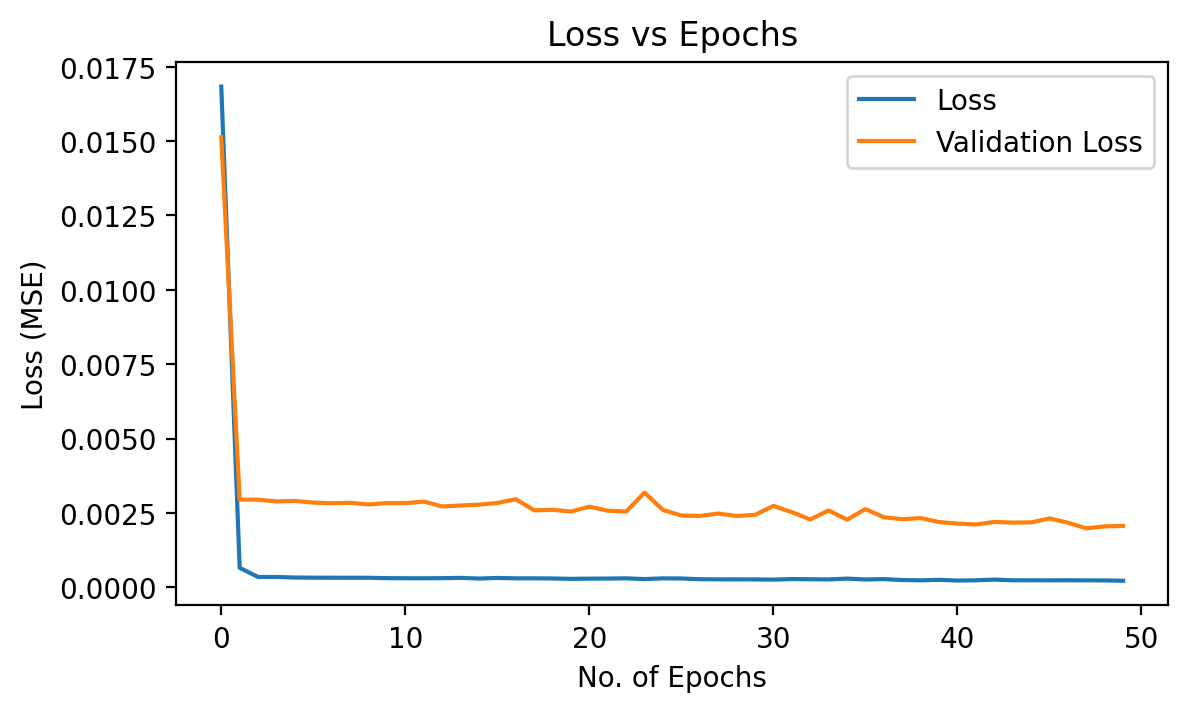

In [446]:
plot(data_label_pairs=[(vanilla_results.history["loss"], "Loss"), (vanilla_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [447]:
# predicted_vanilla =  pd.DataFrame(data=standard_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla =  pd.DataFrame(data=minmax_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [448]:
predicted_vanilla

,Predicted_Close
Date,
2021-02-16,1785.752808
2021-02-17,1778.670776
2021-02-18,1812.713745
2021-02-19,1880.717407
2021-02-20,1929.839600
...,...
2022-05-05,2901.552002
2022-05-06,2816.696045
2022-05-07,2721.506348


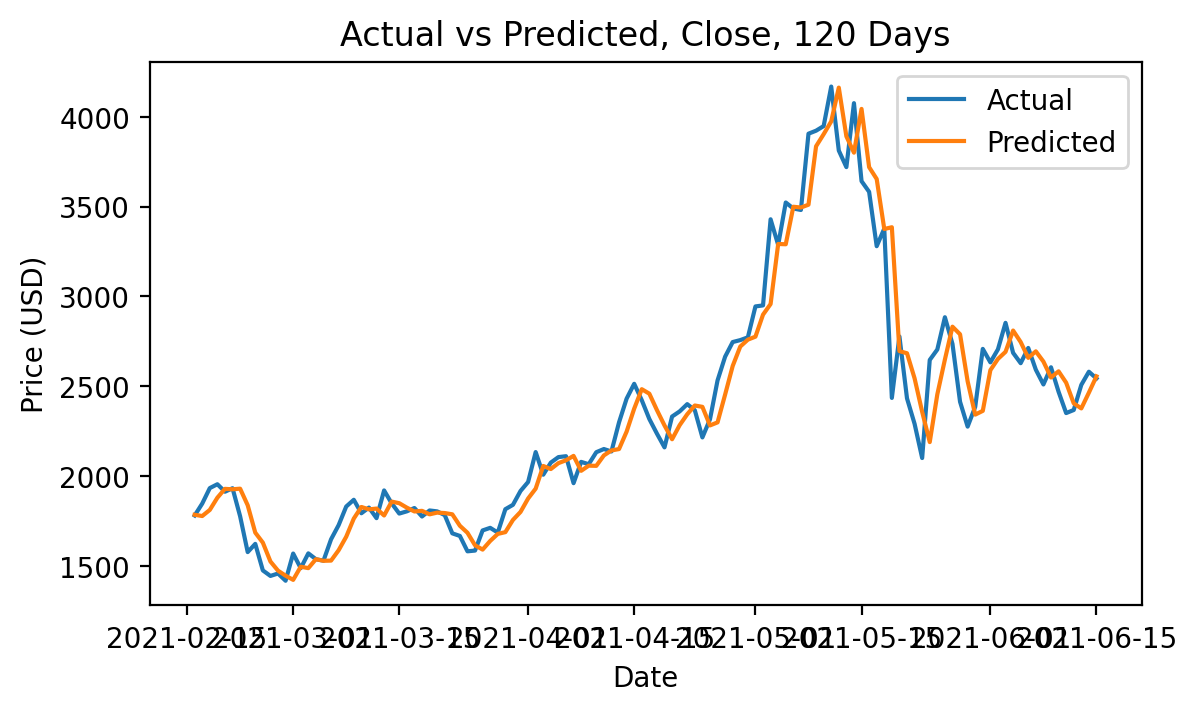

In [449]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_vanilla["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [450]:
performance(actual_uni["Close"][:120], predicted_vanilla["Predicted_Close"][:120])

Performance:
mean squared error:  31174.54023149697
root mean square error:  176.56313384026964
mean absolute error:  120.79790462239583
mean absolute percentage error:  5.026122438449534 %


In [451]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True,  input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
stacked_model.add(tf.keras.layers.LSTM(units=64, activation="relu"))
stacked_model.add(tf.keras.layers.Dense(units=1))
stacked_model.summary()
stacked_model.compile(optimizer="adam", loss="mse")
stacked_results = stacked_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 3, 128)            66560     
                                                                 
 lstm_54 (LSTM)              (None, 64)                49408     
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 5s 12ms/step - loss: 0.0147 - val_loss: 0.0172
Epoch 2/50
57/57 [==============================] - 0s 6ms/step - loss: 7.3408e-04 - val_loss: 0.0035
Epoch 3/50
57/57 [==============================] - 0s 6ms/step - loss: 3.9081e-04 - val_loss: 0.0034
Epoch 4/

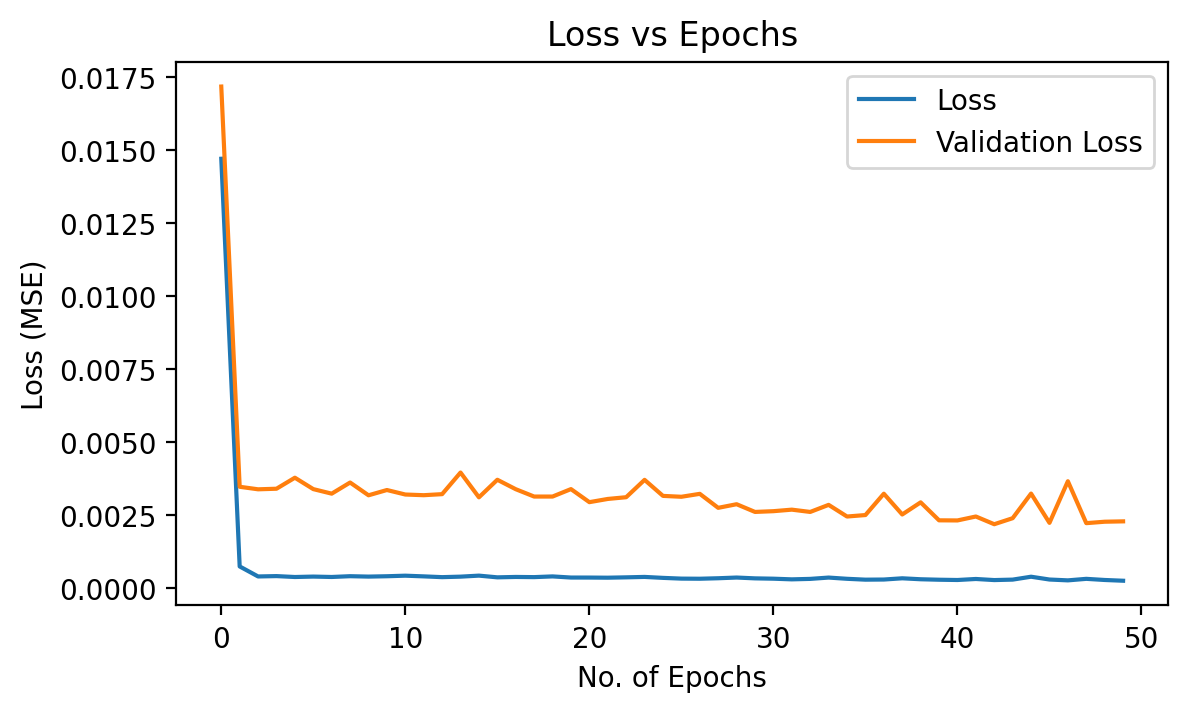

In [452]:
plot(data_label_pairs=[(stacked_results.history["loss"], "Loss"), (stacked_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [453]:
# predicted_stacked =  pd.DataFrame(data=standard_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked =  pd.DataFrame(data=minmax_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked.index.name = "Date"

In [454]:
predicted_stacked

,Predicted_Close
Date,
2021-02-16,1801.785034
2021-02-17,1790.242676
2021-02-18,1808.777710
2021-02-19,1867.563843
2021-02-20,1928.324097
...,...
2022-05-05,2891.094238
2022-05-06,2849.672852
2022-05-07,2739.873779


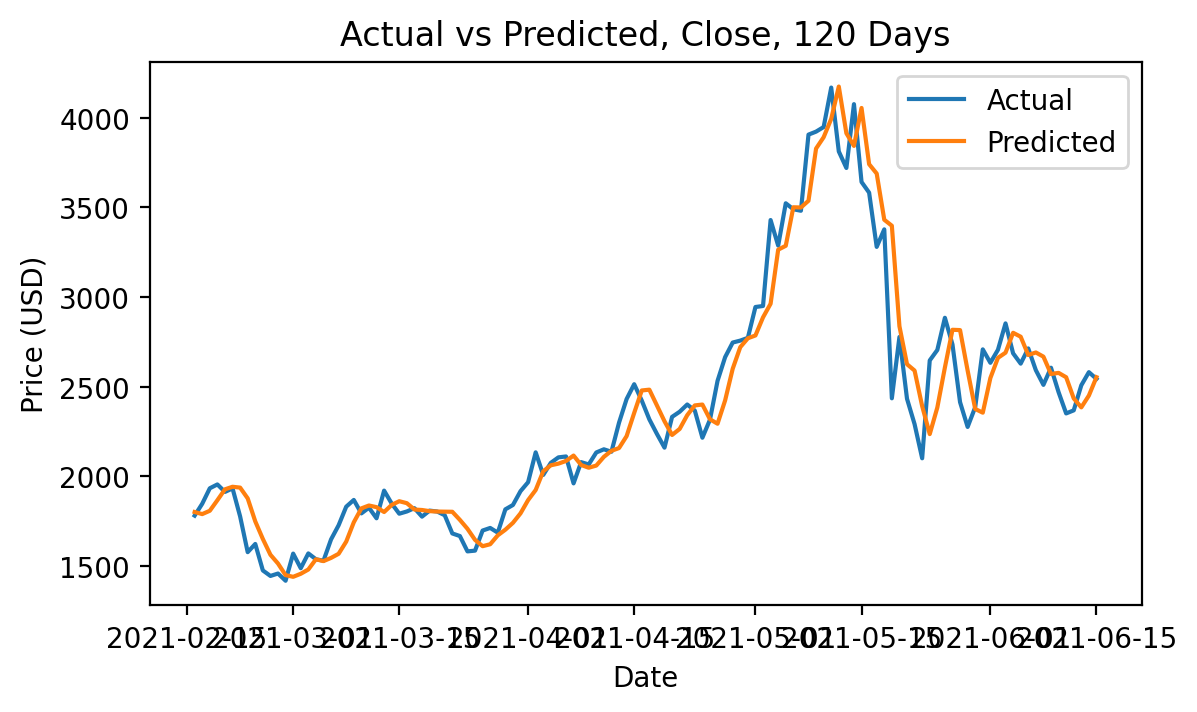

In [455]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [456]:
performance(actual_uni, predicted_stacked)

Performance:
mean squared error:  26176.011656496452
root mean square error:  161.79002335279037
mean absolute error:  120.83062407357352
mean absolute percentage error:  4.2440528819780505 %


In [457]:
bidirectional_model = tf.keras.models.Sequential()
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="relu"), input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
bidirectional_model.add(tf.keras.layers.Dense(units=1))
bidirectional_model.summary()
bidirectional_model.compile(optimizer="adam", loss="mse")
bidirectional_results = bidirectional_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_42 (Dense)            (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 3s 12ms/step - loss: 0.0123 - val_loss: 0.0034
Epoch 2/50
57/57 [==============================] - 0s 5ms/step - loss: 3.8630e-04 - val_loss: 0.0027
Epoch 3/50
57/57 [==============================] - 0s 6ms/step - loss: 3.0505e-04 - val_loss: 0.0028
Epoch 4/50
57/57 [==============================] - 0s 5ms/step - loss: 3.

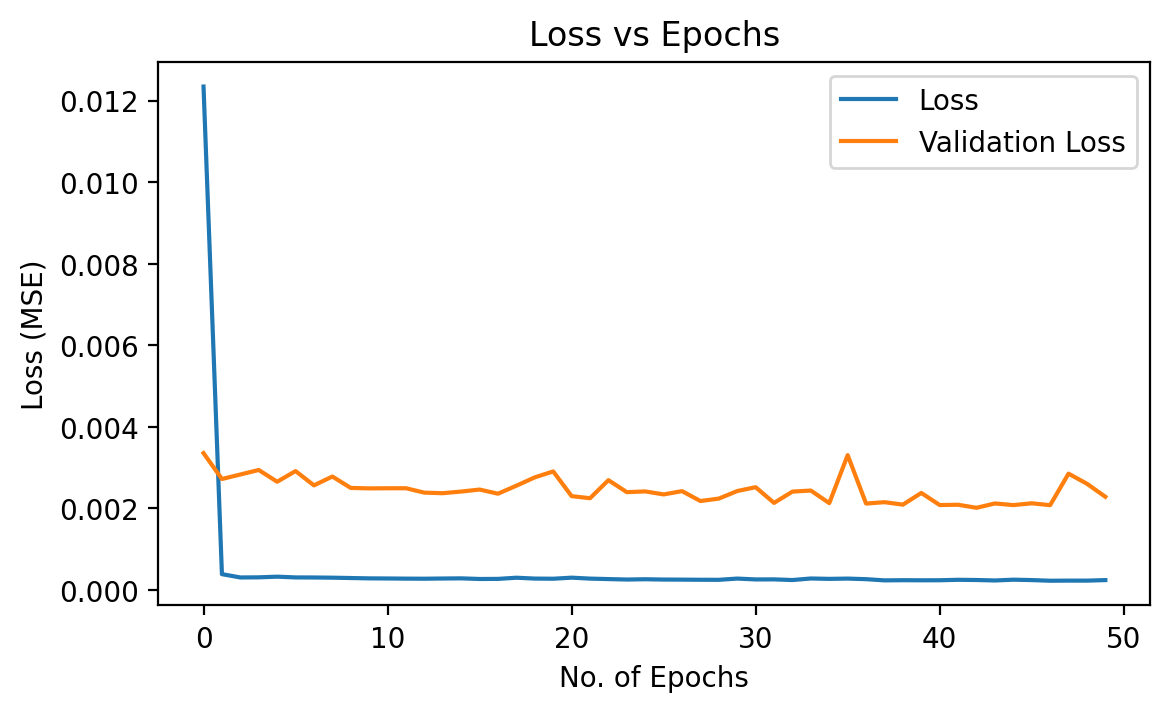

In [458]:
plot(data_label_pairs=[(bidirectional_results.history["loss"], "Loss"), (bidirectional_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [459]:
# predicted_bidirectional =  pd.DataFrame(data=standard_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional =  pd.DataFrame(data=minmax_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional.index.name = "Date"

In [460]:
predicted_bidirectional

,Predicted_Close
Date,
2021-02-16,1756.718994
2021-02-17,1749.117188
2021-02-18,1781.269165
2021-02-19,1848.835571
2021-02-20,1896.946533
...,...
2022-05-05,2835.133789
2022-05-06,2745.913086
2022-05-07,2660.753662


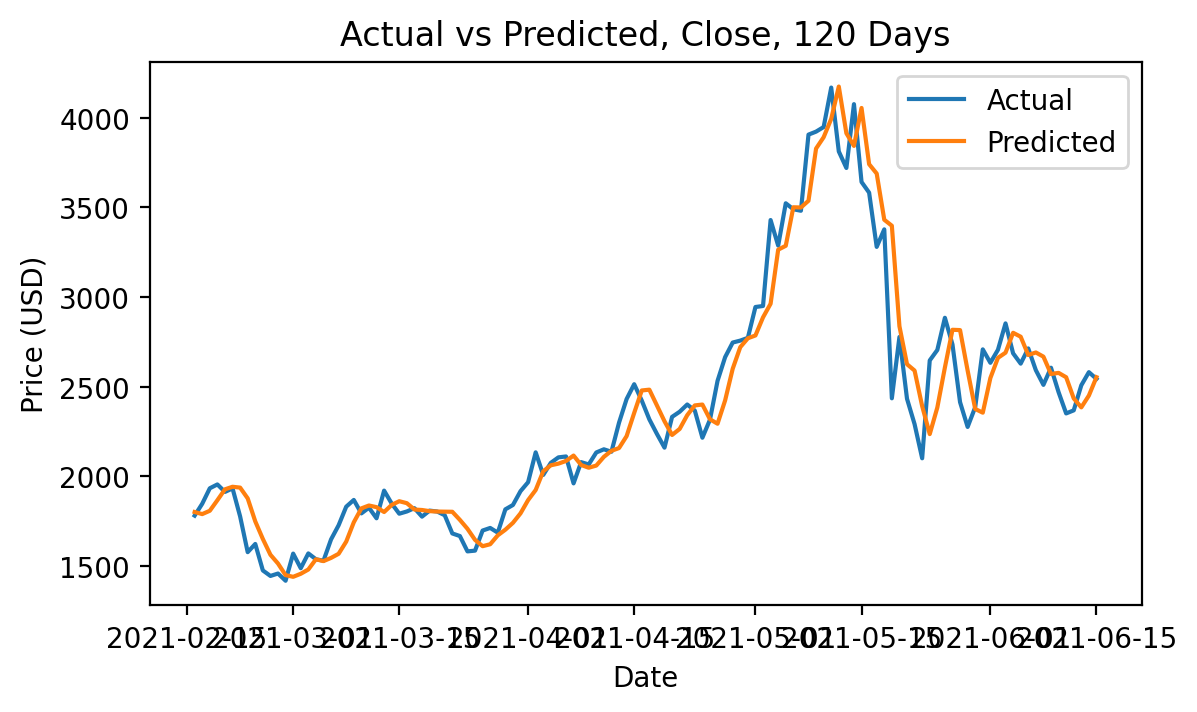

In [461]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [462]:
performance(actual_uni, predicted_bidirectional)

Performance:
mean squared error:  26245.794236669284
root mean square error:  162.0055376728502
mean absolute error:  124.98849690028598
mean absolute percentage error:  4.292783776850332 %


In [463]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104588,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104855,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106389,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105243,0.000184
Volume,0.104588,0.104855,0.106389,0.105243,1.000000,0.000230
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000230,1.000000


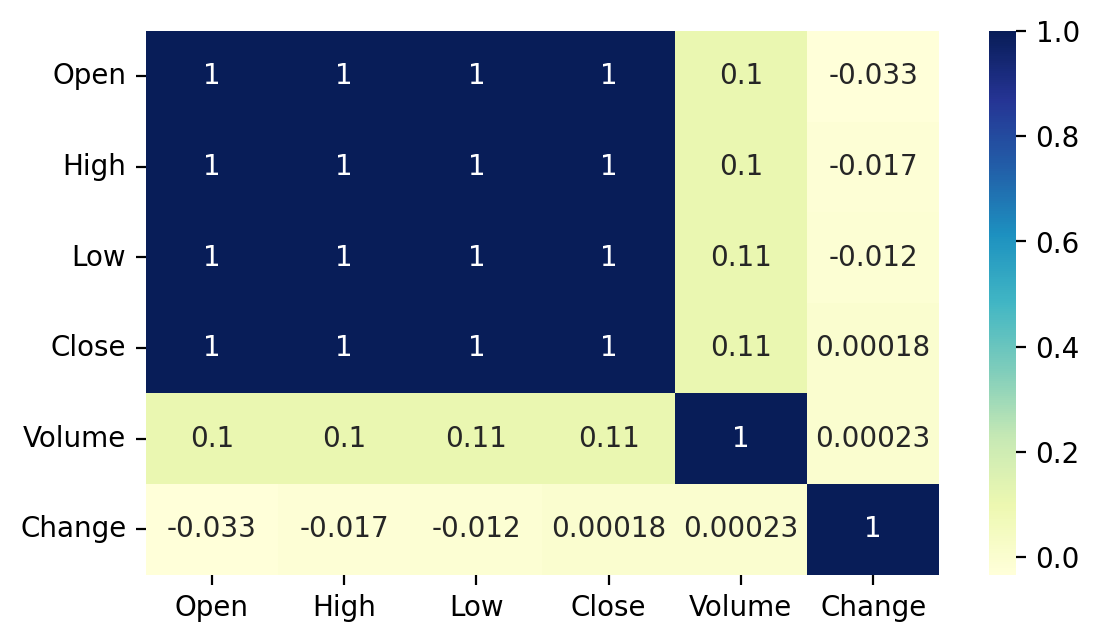

In [464]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [465]:
ether_data_multi = pd.DataFrame(ether_data, columns=["Open", "High", "Low", "Close"])

In [466]:
ether_data_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [467]:
ether_data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
dtypes: float64(4)
memory usage: 88.0 KB


In [468]:
ether_data_multi.describe()

,Open,High,Low,Close
count,2252.000000,2252.000000,2252.000000,2252.000000
mean,812.901239,841.363615,780.354378,813.961607
std,1163.234596,1199.773415,1120.483259,1163.604697
min,6.680000,7.320000,5.860000,6.700000
25%,135.372500,139.487500,130.700000,135.460000
50%,258.000000,268.905000,242.690000,258.900000
75%,754.400000,798.180000,719.557500,759.147500
max,4808.340000,4864.060000,4715.430000,4808.380000


In [469]:
multi_training_size = int(len(ether_data_multi) * 0.90)
multi_test_size = len(ether_data_multi) - multi_training_size
train_ether_multi = ether_data_multi[:multi_training_size]
test_ether_multi = ether_data_multi[multi_training_size:]

In [470]:
train_ether_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2021-09-21,2976.70,3101.88,2659.71,2761.52
2021-09-22,2764.71,3087.97,2740.58,3077.78
2021-09-23,3077.80,3173.00,3035.96,3152.92


In [471]:
test_ether_multi

,Open,High,Low,Close
Date,,,,
2021-09-26,2922.47,3113.65,2740.12,3063.51
2021-09-27,3061.86,3163.86,2926.24,2926.24
2021-09-28,2926.04,2969.18,2791.42,2807.28
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [472]:
# standard_scaler_multi = StandardScaler()
# scaled_train_multi = standard_scaler_multi.fit_transform(train_ether_multi)
# scaled_test_multi = standard_scaler_multi.fit_transform(test_ether_multi)
minmax_scaler_multi = MinMaxScaler()
scaled_train_multi = minmax_scaler_multi.fit_transform(train_ether_multi)
scaled_test_multi = minmax_scaler_multi.fit_transform(test_ether_multi)

In [473]:
scaled_train_multi.shape

(2026, 4)

In [474]:
scaled_test_multi.shape

(226, 4)

In [475]:
multi_train_x, multi_train_y = prepare_for_lstm(scaled_train_multi, 3)
multi_test_x, multi_test_y = prepare_for_lstm(scaled_test_multi, 3)

In [476]:
multi_train_x.shape, multi_train_y.shape

((2023, 3, 4), (2023, 4))

In [477]:
multi_test_x.shape, multi_test_y.shape

((223, 3, 4), (223, 4))

In [478]:
# inversed_actual_multi = standard_scaler_multi.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual_multi = minmax_scaler_multi.inverse_transform(multi_test_y)
actual_multi = pd.DataFrame(data=inversed_actual_multi, index=dates[-1 * len(inversed_actual_multi):], columns=["Open", "High", "Low", "Close"])
actual_multi.index.name = "Date"

In [479]:
actual_multi

,Open,High,Low,Close
Date,,,,
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
2021-10-01,2999.86,3329.32,2972.75,3309.13
2021-10-02,3309.14,3467.95,3265.97,3388.97
2021-10-03,3388.83,3485.48,3346.63,3417.34
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [496]:
multi_model = tf.keras.models.Sequential()
multi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True), input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.LSTM(units=32, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.Dense(units=multi_train_x.shape[2]))
multi_model.summary()
multi_model.compile(optimizer="adam", loss="mse")
multi_results = multi_model.fit(multi_train_x, multi_train_y, batch_size=128, epochs=50, verbose=1, validation_data=(multi_test_x, multi_test_y))

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirecti  (None, 3, 256)           136192    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 3, 256)            0         
                                                                 
 lstm_71 (LSTM)              (None, 3, 64)             82176     
                                                                 
 dropout_16 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_72 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                     

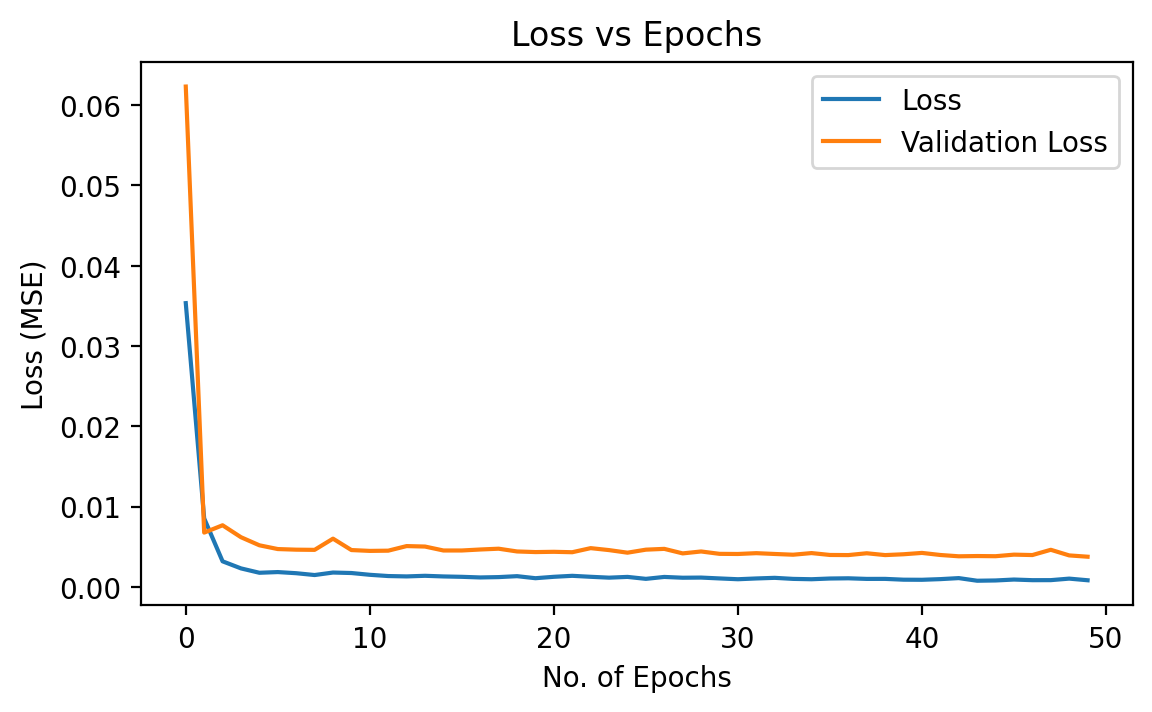

In [502]:
plot(data_label_pairs=[(multi_results.history["loss"], "Loss"), (multi_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [498]:
# predicted_multi =  pd.DataFrame(data=standard_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_multi =  pd.DataFrame(data=minmax_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [499]:
predicted_multi

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close
2021-09-29,2976.691162,3061.460449,2783.777588,2990.124512
2021-09-30,2933.968994,3018.829102,2736.755127,2946.240479
2021-10-01,2935.755859,3020.599365,2739.417236,2948.878906
2021-10-02,3060.384521,3144.098633,2877.916748,3077.447266
2021-10-03,3236.178711,3317.627441,3072.015869,3256.823975
...,...,...,...,...
2022-05-05,2889.312256,2974.640137,2688.062256,2901.070557
2022-05-06,2877.138672,2962.793945,2674.262695,2888.263184
2022-05-07,2833.638672,2919.605957,2625.746338,2842.833984
2022-05-08,2757.527588,2843.900146,2541.268311,2764.032471


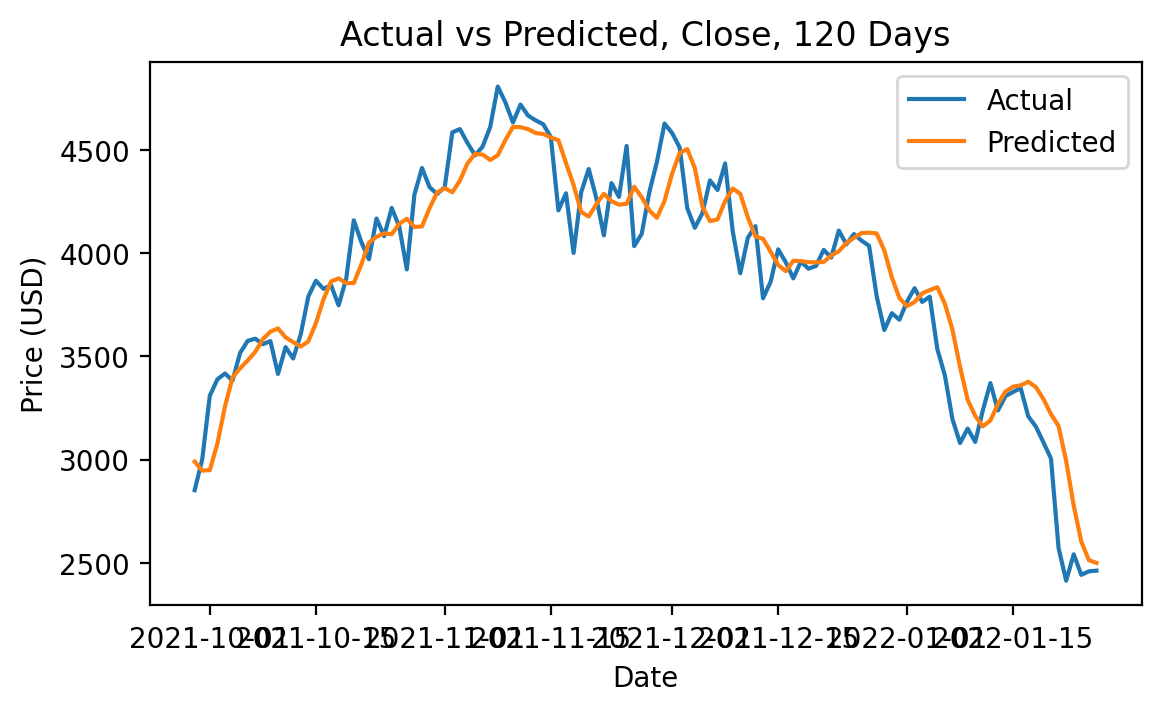

In [500]:
plot(data_label_pairs=[(actual_multi["Close"][:120], "Actual"), (predicted_multi["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [501]:
performance(actual_multi["Close"], predicted_multi["Predicted_Close"])

Performance:
mean squared error:  29463.149982225485
root mean square error:  171.6483323024884
mean absolute error:  132.94369285138728
mean absolute percentage error:  4.061762715477287 %
